Matthew Dacre 2091295

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

## Activation Functions

The activation functions that I will be using are tanh, sigmoid and reLU

In [2]:
# Activation Functions

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1-np.tanh(x)**2

def sigmoid(x):
    return 1/(1+np.exp(-1*x))

def sigmoid_prime(x):
    return 1 - sigmoid(x)

def reLU(x):
    return np.maximum(0, x)

def reLU_prime(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x


## Initialising weights

The following code initialises the weights between 0 and 1 for a given input, oputput and hidden dimensions

In [3]:
def init_weights(input, output):
    '''
    Initialises weights between 0 and 1 given input and output dimensions
    '''
    # Theta: [output x input + 1]
    return np.random.random((output, input+1))

def init_layers(input_dim, output_dim, hidden_dim = 0, num_hidden = 0):
    if num_hidden == 0 or hidden_dim == 0:
        # No hidden layers, thetas only need to be from input nodes to output nodes
        return [init_weights(input_dim, output_dim)]

    # Have at least one hidden layer
    outputThetas = [init_weights(input_dim, hidden_dim)]

    for _ in range(num_hidden - 1):
        # Get weights between hidden layers
        outputThetas.append(init_weights(hidden_dim, hidden_dim))
    # Get weights from last hidden layer to output layer
    outputThetas.append(init_weights(hidden_dim, output_dim))

    return outputThetas

## Forward propogation

The functions below perform forward propogation on an array of input vectors x, and return boththe activated and non-activated results

In [4]:
# Forward Propogation
def forward_propogation_epoch(input, theta, activation=sigmoid):
    '''
    Performs matrix multiplication. Returns Activated and non activated results.
    '''
    input = np.insert(input, 0, 1)
    return (activation(np.dot(theta, input.T)), np.dot(theta, input.T))

def forward_propogation(x, thetas, activation):
    '''
    returns the activation values in each layer for a training instance x
    '''
    curr = [x]
    z = [x]
    for i, t in enumerate(thetas):
        r = forward_propogation_epoch(curr[i], t, activation)
        curr.append(r[0])
        z.append(r[1])

    return (curr, z)
    

In [5]:
# Reading in data
df = pd.read_csv("Fish.csv")

y = df['Weight'].to_numpy()
x = df[['Length1','Length2','Length3','Height','Width']].to_numpy()

# Splitting datasets
x_train, x_test, y_train, y_test = train_test_split(x, y)


In [6]:
def oneHidden(x_train, x_test, y_train, y_test, alpha, lmbda, activation, activation_prime, k,seed=42):
    input_layer, hidden_layer, num_hidden, output_layer = 5, 500, 1, 1

    np.random.seed(seed)
    for _ in range(k):
        avDistance = np.zeros((100, 1))
        thetas = init_layers(input_layer, output_layer, hidden_layer, num_hidden)

        lmbdas = [np.zeros(thetas[0].shape), np.zeros(thetas[1].shape)]

        lmbdas[0][:, 1:] = lmbda
        lmbdas[1][:, 1:] = lmbda

        for epoch in range(100):
            m = 0
            for i in range(len(x_test)):
                a, z = forward_propogation(x_test[i], thetas, activation)
                m += abs((a[-1] - y_test[i]))
            avDistance[epoch] += m/len(y_test)


            Del1 = 0
            Del2 = 0

            for i, x in enumerate(x_train):
                a, z = forward_propogation(x, thetas, activation)

                # Performing backpropogation by hand
                # z holds unactivated values

                del3 = a[-1] - y_train[i]
                del2 = np.multiply(thetas[1].T.dot(del3), activation_prime(np.insert(z[1], 0, 1)))

                Del1 = Del1 + del2.dot(np.insert(a[1], 0, 1).T)
                Del2 = Del2 + del3.dot(a[2].T)

            D1 = Del1*(1/len(y_train)) + lmbdas[0]*thetas[0]
            D2 = Del2*(1/len(y_train)) + lmbdas[1]*thetas[1]

            #print(thetas)
            thetas[0] = thetas[0] - alpha*D1
            thetas[1] = thetas[1] - alpha*D2

           

    return (avDistance/k)

Average time in seconds taken to train the model with a reLU activation function:  0.9828442799975164 
Average distance from the prediction to the ground truth value of the model in the test set:  [33.07643609]
Average time in seconds taken to train the model with a tanh activation function:  0.9729353300004732 
Average distance from the prediction to the ground truth value of the model in the test set:  [43.9815]
Average time in seconds taken to train the model with a sigmoid activation function:  1.1779324100003579 
Average distance from the prediction to the ground truth value of the model in the test set:  [43.9815]


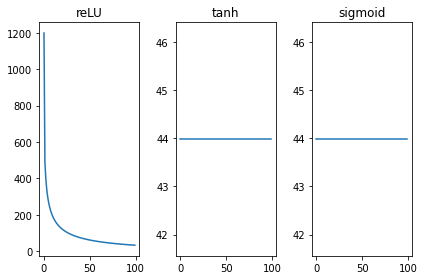

In [7]:
import time

start = time.perf_counter()
perf1 = oneHidden(x_train, x_test, y_train, y_test, 1e-9, 1e-3, reLU, reLU_prime, 10, seed=1)
end = time.perf_counter()

print("Average time in seconds taken to train the model with a reLU activation function: ", (end - start)/10, "\nAverage distance from the prediction to the ground truth value of the model in the test set: " ,perf1[-1])

start = time.perf_counter()
perf2 = oneHidden(x_train, x_test, y_train, y_test, 1e-9, 1e-3, tanh, tanh_prime, 10, seed=2)
end = time.perf_counter()

print("Average time in seconds taken to train the model with a tanh activation function: ", (end - start)/10, "\nAverage distance from the prediction to the ground truth value of the model in the test set: " ,perf2[-1])

start = time.perf_counter()
perf3 = oneHidden(x_train, x_test, y_train, y_test, 1e-9, 1e-3, sigmoid, sigmoid_prime, 10, seed=3)
end = time.perf_counter()

print("Average time in seconds taken to train the model with a sigmoid activation function: ", (end - start)/10, "\nAverage distance from the prediction to the ground truth value of the model in the test set: " ,perf3[-1])

fig, axs = plt.subplots(ncols=3)

axs[0].plot(perf1)
axs[0].set_title("reLU")

axs[1].plot(perf2)
axs[1].set_title("tanh")

axs[2].plot(perf3)
axs[2].set_title("sigmoid")

fig.tight_layout()

plt.show()


## Effect of different activation functions

As can be seen above, the best performing activation function for this data set, with $\alpha=1e-9$, $\lambda=1e-3$, and the network containikng one layer with 500 nodes was the reLU activation function. It seems to have taken slower to converge than the other activation functions, shown by the graph of average etsting error, but with a better final accuracy. This may be due to the fact that there can be a larger variation in values from data activated with a reLU activation function than data activated with a sigmoid activation function.

In [8]:
def twoHidden(x_train, x_test, y_train, y_test, alpha, lmbda, activation, activation_prime, k,seed=42):
    input_layer, hidden_layer, num_hidden, output_layer = 5, 100, 2, 1
    np.random.seed(seed)

    for _ in range(k):
        avDistance = np.zeros((100, 1))
        thetas = init_layers(input_layer, output_layer, hidden_layer, num_hidden)

        lmbdas = [np.zeros(thetas[0].shape), np.zeros(thetas[1].shape), np.zeros(thetas[2].shape)]
        lmbdas[0][:, 1:] = lmbda
        lmbdas[1][:, 1:] = lmbda
        lmbdas[2][:, 1:] = lmbda

        for epoch in range(100):
            m = 0
            for i in range(len(x_test)):
                a, z = forward_propogation(x_test[i], thetas, activation)
                m += abs((a[-1] - y_test[i]))
            avDistance[epoch] += m/len(y_test)
            
            Del1 = 0
            Del2 = 0
            Del3 = 0
            for i, x in enumerate(x_train):
                a, z = forward_propogation(x, thetas, activation)

                # Performing backpropogation by hand
                # z holds unactivated values

                del4 = a[-1] - y_train[i]
                del3 = np.multiply(thetas[2].T.dot(del4), activation_prime(np.insert(z[2], 0, 1)))
                del2 = np.multiply(thetas[1].dot(del3), activation_prime(z[1]))

                Del3 += del4.dot(a[3].T)
                Del2 += del3.dot(np.insert(a[2], 0, 1).T)
                Del1 += del2.dot(a[1].T)

            D1 = 1/len(x_train) * Del1 + lmbdas[0]*thetas[0]
            D2 = 1/len(x_train) * Del2 + lmbdas[1]*thetas[1]
            D3 = 1/len(x_train) * Del3 + lmbdas[2]*thetas[2]

            thetas[0] -= alpha*D1
            thetas[1] -= alpha*D2
            thetas[2] -= alpha*D3

    return(avDistance/k)

The average time taken to train the model: 5.4127182099997295 
The final average testing error: [44.0815]


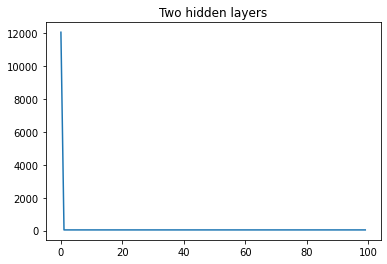

In [9]:
import time

start = time.perf_counter()
perf = twoHidden(x_train, x_test, y_train, y_test, 1e-9, 1e-3, reLU, reLU_prime, 10)
end = time.perf_counter()

print("The average time taken to train the model:", (end-start)/10, "\nThe final average testing error:", perf[-1])
plt.title("Two hidden layers")
plt.plot(perf)

plt.show()

## Multiple Hidden Layers

As seen above, the network with multiple hidden layers (2 layers of 100 neurons), had a similar final performance to the single hidden layer networks, but appeared to have a significantly quicker convergence. The increased learning time may be due to unnecessary calculations being performed after convergence is achieved.